In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [25]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [26]:
df = pd.read_csv("/content/drive/MyDrive/INDONESIA AI/DWIMAS ARIE/SALES FORECASTING/store5.csv")

In [27]:
# Konversi kolom 'date' menjadi datetime
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

# Hapus fitur yang tidak diperlukan
df.drop(columns=["id", "store_nbr", "dcoilwtico"], inplace=True)

In [28]:
# Filter untuk produk 'POULTRY'
def filter_family(df: pd.DataFrame, family: str) -> pd.DataFrame:
    return df[df["family"] == family].reset_index(drop=True)

df_poultry = filter_family(df, "POULTRY")

# Mengatur kolom 'date' sebagai indeks
df_poultry.set_index("date", inplace=True)

# Resampling data mingguan dan transformasi log
df_poultry = df_poultry['sales'].resample("W-MON").sum()
df_poultry = np.log(df_poultry)
df_poultry.index = pd.date_range(start=df_poultry.index.min(), end=df_poultry.index.max(), freq='W-MON')
df_poultry = df_poultry.to_frame()

In [29]:
# Membagi data menjadi train dan test
train_size = int(len(df_poultry) * 0.8)
train_data, test_data = df_poultry.iloc[:train_size], df_poultry.iloc[train_size:]



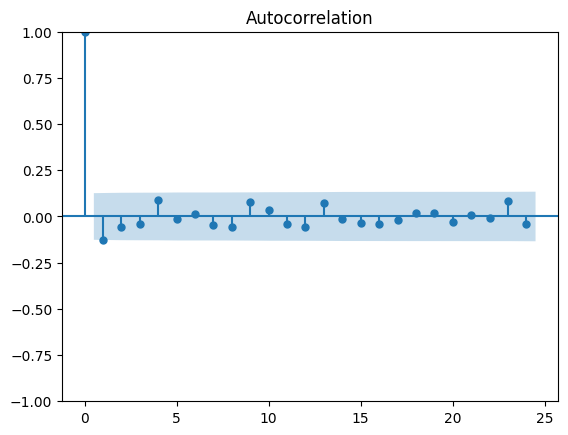

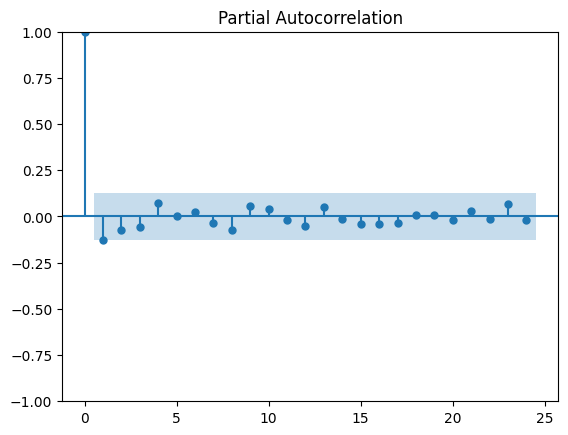

In [30]:
# Step 2: Plot ACF and PACF to determine p and q
plot_acf(df_poultry['sales'].diff().dropna())
plot_pacf(df_poultry['sales'].diff().dropna())
plt.show()

In [31]:
# Training model SARIMA dengan parameter terbaik
sarima_model = SARIMAX(train_data['sales'], order=(0, 1, 1), seasonal_order=(0, 0, 0, 12)).fit()

print(sarima_model.summary())

# Membuat prediksi
train_pred = sarima_model.predict(start=train_data.index.min(), end=train_data.index.max(), typ="levels")
test_pred = sarima_model.predict(start=test_data.index.min(), end=test_data.index.max(), typ="levels")

# Mengembalikan transformasi log
train_pred_exp = np.exp(train_pred)
test_pred_exp = np.exp(test_pred)
train_data_exp = np.exp(train_data['sales'])
test_data_exp = np.exp(test_data['sales'])

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  193
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 159.375
Date:                Mon, 24 Jun 2024   AIC                           -314.750
Time:                        12:57:36   BIC                           -308.235
Sample:                    01-07-2013   HQIC                          -312.112
                         - 09-12-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4878      0.046    -10.598      0.000      -0.578      -0.398
sigma2         0.0111      0.001     22.211      0.000       0.010       0.012
Ljung-Box (L1) (Q):                   1.18   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [32]:
# Menghitung metrik RMSE dan MAPE
train_rmse = mse(train_data_exp, train_pred_exp, squared=False)
test_rmse = mse(test_data_exp, test_pred_exp, squared=False)

train_mape = mape(train_data_exp, train_pred_exp) * 100
test_mape = mape(test_data_exp, test_pred_exp) * 100

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")

Train RMSE: 228.4122896795124
Test RMSE: 290.0817250616542
Train MAPE: 7.660883168123313
Test MAPE: 21.43201060340106


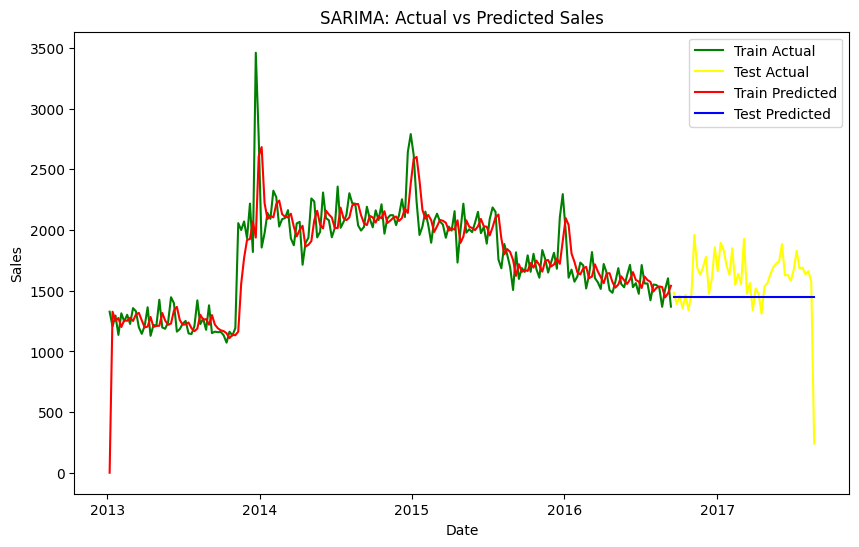

In [33]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data_exp, color='green', label='Train Actual')
plt.plot(test_data.index, test_data_exp, color='yellow', label='Test Actual')
plt.plot(train_data.index, train_pred_exp, color='red', label='Train Predicted')
plt.plot(test_data.index, test_pred_exp, color='blue', label='Test Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMA: Actual vs Predicted Sales')
plt.legend()
plt.show()